## MAGIC DL3 spectrum with gammapy
author:
* Cosimo Nigro (cosimonigro2@gmail.com)

In [1]:
#setup
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('ggplot')

# check package versions
import numpy as np
import astropy
import regions
import sherpa
import os

print('numpy:', np.__version__)
print('astropy', astropy.__version__)
print('regions', regions.__version__)
print('sherpa', sherpa.__version__)

numpy: 1.13.3
astropy 2.0.2
regions 0.2
sherpa 4.9.1


In [2]:
import gammapy
gammapy.version.version

'0.7.dev5441'

In [3]:
# units and coordinates from astropy
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord, Angle
from astropy.table import Table
# regions 
from regions import CircleSkyRegion
# Datastore is the interface to the index of observations 
import gammapy.data as data # to many functions to import
# The background method
import gammapy.background as background
# Some utility function to deal with energy axis (log binning with a unit etc)
from gammapy.utils.energy import EnergyBounds
# The class performing the extraction and extraction results
from gammapy.spectrum import SpectrumExtraction, SpectrumObservation, SpectrumFit, SpectrumResult
# Spectral models
from gammapy.spectrum.models import LogParabola
# Utilities for flux points plotting
from gammapy.spectrum import FluxPoints, SpectrumEnergyGroupMaker, FluxPointEstimator
# A class to deal with exclusion regions
from gammapy.image import SkyImage
from gammapy.extern.pathlib import Path

# defining the DataStore object

In [4]:
MAGIC_DIR = '../data/magic'

datastore = data.DataStore.from_dir(MAGIC_DIR)
obs_ids = [5029747,5029748]

datastore.info()

obs_list = datastore.obs_list(obs_ids)


Data store summary info:
name: noname

HDU index table:
BASE_DIR: ../data/magic
Rows: 8
OBS_ID: 5029747 -- 5029748
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti']

Observation table:
Number of observations: 2


## defining Target and Exclusion regions

The next step is to define a signal extraction region, also known as **on region**. This is realized with the CircleSkyRegion object. Since we have generated the IRFs with Hadronness and (especially) $\theta^2$ cuts constant over all the enrgy range, **set** a on region radius equal to your $\theta^2$ cut.

In [5]:
# fetch the cooordinate of the object we are wobbling around from the fits file
RA_OBJ = 83.63
DEC_OBJ = 22.01

target_position = SkyCoord(ra=RA_OBJ, dec=DEC_OBJ, unit='deg', frame='icrs') # coordinates of the Crab 
on_region_radius = Angle('0.141 deg') # we use 0.02 theta2 cut to generate the files
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

for defining the **exclusion region** we will use a predefined mask that is in **gammapy-extra**, you should download this repository because it contains supplementary material sometimes required, so:    
    ```    git clone https://github.com/gammapy/gammapy-extra.git```       
    ```    export GAMMAPY_EXTRA="/home/wherever/you/have/downloaded/it/"```

In [6]:
EXCLUSION_FILE = '$GAMMAPY_EXTRA/datasets/exclusion_masks/tevcat_exclusion.fits'

allsky_mask = SkyImage.read(EXCLUSION_FILE)

exclusion_mask = allsky_mask.cutout(
    position=on_region.center,
    size=Angle('6 deg'),
)

## Estimate background

We will manually perform a background estimate by placing reflected regions around the pointing position and looking at the source statistics. This will result in a gammapy.background.BackgroundEstimate that serves as input for other classes in gammapy.

BackgroundEstimate
 Method: Reflected Regions
 on region
 Region: CircleSkyRegion
center: <SkyCoord (ICRS): (ra, dec) in deg
    ( 83.63,  22.01)>
radius: 0.141 deg
 EventList info:
- Number of events: 711
- Median energy: 0.14861749112606049 TeV
- Median azimuth: 104.7149658203125
- Median altitude: 69.85789489746094

 off region
 [<CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 184.90816828, -5.54231211)>, radius=0.141516035710462 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 184.91819792, -5.2594578)>, radius=0.14151603571010002 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 184.7394628, -5.04000186)>, radius=0.14151603571010002 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 184.46043334, -4.99257072)>, radius=0.14151603571010002 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 184.21922371, -5.14064189)>, radius=0.14151603571010002 deg)>, <CircleSkyRegion(<SkyCoord (Galactic): (l, b) in deg
    ( 

(<matplotlib.figure.Figure at 0x7ff75e0a1f28>,
 None)

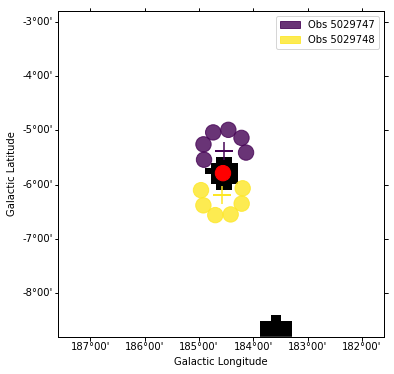

In [7]:
background_estimator = background.ReflectedRegionsBackgroundEstimator(
    obs_list=obs_list,
    on_region=on_region,
    exclusion_mask = exclusion_mask)

background_estimator.run()
print(background_estimator.result[0])
# we plot it!
plt.figure(figsize=(6,6))
background_estimator.plot()

## Source statistic

Next we're going to look at the overall source statistics in our signal region. For more info about what debug plots you can create check out the **ObservationSummary** class.

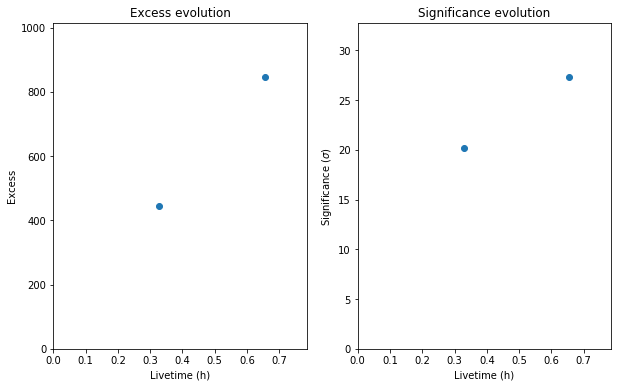

In [8]:
stats = []
for obs, bkg in zip(obs_list, background_estimator.result):
    stats.append(data.ObservationStats.from_obs(obs, bkg))
    
obs_summary = data.ObservationSummary(stats)
fig = plt.figure(figsize=(10,6))
ax1=fig.add_subplot(121)

obs_summary.plot_excess_vs_livetime(ax=ax1)
ax2=fig.add_subplot(122)
obs_summary.plot_significance_vs_livetime(ax=ax2)

## Spectrum extraction
Here we will perform the spectrum extraction and obtain the MAGIC Crab spectrum in FITS file.
We use the same binning in E-reco e_true tahat was used for exporting the IRFs

In [9]:
MAGIC_reco_bins_edges = [5.54354939e-03, 7.53565929e-03, 1.02436466e-02, 1.39247665e-02,
                         1.89287203e-02, 2.57308770e-02, 3.49774320e-02, 4.75467958e-02,
                         6.46330407e-02, 8.78593369e-02, 1.19432151e-01, 1.62350858e-01,
                         2.20692676e-01, 3.00000000e-01, 4.07806917e-01, 5.54354939e-01,
                         7.53565929e-01, 1.02436466e+00, 1.39247665e+00, 1.89287203e+00,
                         2.57308770e+00, 3.49774320e+00, 4.75467958e+00, 6.46330407e+00,
                         8.78593369e+00, 1.19432151e+01, 1.62350858e+01, 2.20692676e+01,
                         3.00000000e+01, 4.07806917e+01, 5.54354939e+01] * u.TeV

MAGIC_true_bins_edges = [5.54354939e-03, 8.59536081e-03, 1.33272426e-02, 2.06640999e-02,
                         3.20400130e-02, 4.96785457e-02, 7.70273690e-02, 1.19432151e-01,
                         1.85181435e-01, 2.87126737e-01, 4.45194537e-01, 6.90281154e-01,
                         1.07029182e+00, 1.65950436e+00, 2.57308770e+00, 3.98961308e+00,
                         6.18595803e+00, 9.59142554e+00, 1.48716566e+01, 2.30587383e+01,
                         3.57529376e+01, 7.91911869e+01] * u.TeV


extraction = SpectrumExtraction(obs_list=obs_list,
                                bkg_estimate=background_estimator.result,
                                containment_correction=False,
                                e_reco = MAGIC_reco_bins_edges,
                                e_true = MAGIC_true_bins_edges
                               )

extraction.run()

/afs/ifh.de/group/amanda/scratch/cosimo/miniconda3/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in true_divide
  *arrays, **kwargs)


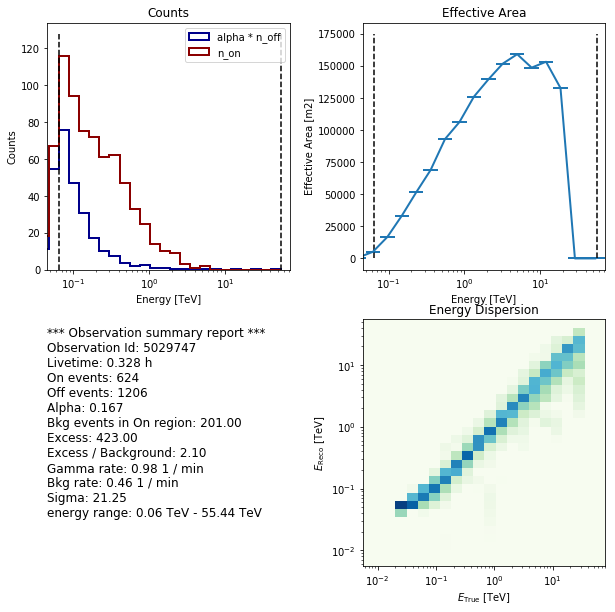

In [10]:
# gammapy diagnostic plots
extraction.observations[0].peek()

## fit spectrum
We will now fit the spectrum with a log parabola

In [11]:
model = LogParabola(amplitude = 3.80*1e-11 * u.Unit('cm-2 s-1 TeV-1'),
                    reference = 1 * u.Unit('TeV'),
                    alpha = 2.47 * u.Unit(''),
                    beta = 0.24 * u.Unit(''))

fit = SpectrumFit(obs_list = extraction.observations, model = model)

fit.fit()
fit.est_errors()

fit_result = fit.result

/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:203: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:204: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))



Fit result info 
--------------- 
Model: LogParabola

Parameters: 

	   name     value     error         unit      min max frozen
	--------- --------- --------- --------------- --- --- ------
	amplitude 4.448e-11 2.985e-12 1 / (cm2 s TeV) nan nan  False
	reference 1.000e+00 0.000e+00             TeV nan nan   True
	    alpha 2.480e+00 8.626e-02                 nan nan  False
	     beta 1.425e-01 4.258e-02                 nan nan  False

Covariance: 

	name/name amplitude   alpha     beta  
	--------- --------- --------- --------
	amplitude  8.91e-24 -8.27e-14 1.63e-14
	    alpha -8.27e-14   0.00744  0.00307
	     beta  1.63e-14   0.00307  0.00181 

Statistic: 12.613 (wstat)
Fit Range: [  0.06463304  55.4354939 ] TeV



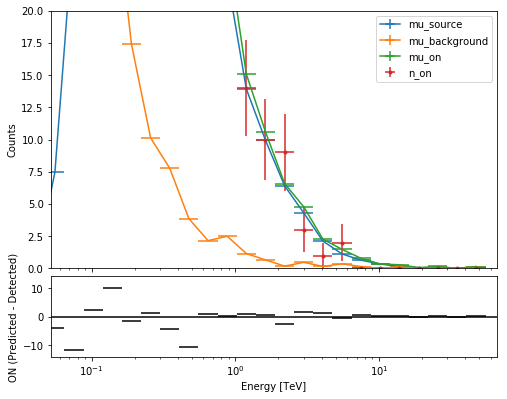

In [12]:
ax0, ax1 = fit_result[0].plot(figsize=(8,8))
ax0.set_ylim(0, 20)
print(fit_result[0])

## Compute flux points
Here we compute the flux points after the fit, we have to define a stack of observation (through ```observations.stack()```) in order to repeat the fit in each energy band delimited by the bin.

In [13]:
ebounds = MAGIC_true_bins_edges[6:-4]
stacked_obs = extraction.observations.stack()

seg = SpectrumEnergyGroupMaker(obs=stacked_obs)
#seg.compute_range_safe()
seg.compute_groups_fixed(ebounds=ebounds)

print(seg.groups)

SpectrumEnergyGroups:
energy_group_idx bin_idx_min bin_idx_max  bin_type   energy_min   energy_max 
                                                        TeV          TeV     
---------------- ----------- ----------- --------- ------------- ------------
               0           0           8 underflow 0.00554354939 0.0878593369
               1           9           9    normal  0.0878593369  0.119432151
               2          10          10    normal   0.119432151  0.162350858
               3          11          11    normal   0.162350858  0.220692676
               4          12          13    normal   0.220692676  0.407806917
               5          14          14    normal   0.407806917  0.554354939
               6          15          16    normal   0.554354939   1.02436466
               7          17          17    normal    1.02436466   1.39247665
               8          18          19    normal    1.39247665    2.5730877
               9          20          20  

/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/poisson.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  temp = (alpha + 1) / (n_on + n_off)
/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/poisson.py:385: RuntimeWarning: divide by zero encountered in log
  m = n_off * log(n_off * temp)
/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  l = n_on * log(n_on * temp / alpha)


/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:161: RuntimeWarning: divide by zero encountered in log
  term2_ = - n_on * np.log(mu_sig + alpha * mu_bkg)
/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:166: RuntimeWarning: divide by zero encountered in log
  term3_ = - n_off * np.log(mu_bkg)
/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:203: RuntimeWarning: divide by zero encountered in log
  term1 = - n_on * (1 - np.log(n_on))
/afs/ifh.de/user/c/cosimo/.local/lib/python3.6/site-packages/gammapy/stats/fit_statistics.py:204: RuntimeWarning: divide by zero encountered in log
  term2 = - n_off * (1 - np.log(n_off))


    e_ref         e_min        e_max    ...     dnde_errp         dnde_errn    
     TeV           TeV          TeV     ...  1 / (cm2 s TeV)   1 / (cm2 s TeV) 
-------------- ------------ ----------- ... ----------------- -----------------
0.102436466121 0.0878593369 0.119432151 ... 8.57438730727e-10 8.25199888809e-10
0.139247664927  0.119432151 0.162350858 ... 4.05662977415e-10 3.91991337075e-10
 0.18928720322  0.162350858 0.220692676 ... 2.04164274834e-10 1.99233584978e-10
0.299999999673  0.220692676 0.407806917 ... 5.49854572688e-11 5.40184677281e-11
0.475467957487  0.407806917 0.554354939 ... 3.74445764158e-11 3.52945040917e-11
0.753565928508  0.554354939  1.02436466 ... 9.43061500945e-12 8.78781072962e-12
 1.19432151037   1.02436466  1.39247665 ... 5.58885083058e-12 4.90283747231e-12
 1.89287203494   1.39247665   2.5730877 ... 1.69936541005e-12 1.51650574817e-12
 3.00000000095    2.5730877   3.4977432 ... 7.91262470854e-13 5.75010075672e-13
 4.07806917169    3.4977432  4.75467958 

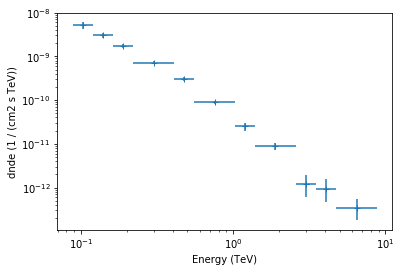

In [14]:
fpe = FluxPointEstimator(
    obs=stacked_obs,
    groups=seg.groups,
    model=fit_result[0].model,
)
fpe.compute_points()

print(fpe.flux_points.table)

print('\n\n E_true binning \n\n e_max [TeV]      e_min [TeV]')
for i in range(len(ebounds)-1):
    print(ebounds[i+1].value,  ebounds[i].value)
# Have to set flux unit here because flux points default unit is ph / ... which raises a unit conversion error
fpe.flux_points.plot(flux_unit = 'cm-2 s-1 TeV-1')

(array([-0.15457869, -0.09358405, -0.06169751,  0.00897346,  0.18112137,
       -0.00559228, -0.1270014 ,  0.01089801, -0.52149437, -0.10802221,
        0.29825755]), array([ 0.13918499,  0.11732607,  0.10838579,  0.07603438,  0.13986965,
        0.10261084,  0.1836209 ,  0.18616736,  0.27471602,  0.51209142,
        0.70604856]))


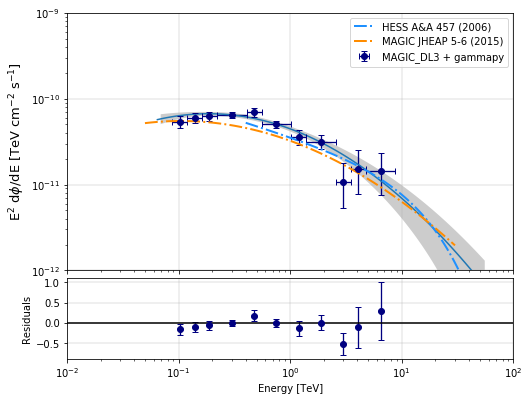

In [15]:
from gammapy.spectrum import CrabSpectrum
crab_hess_ecpl = CrabSpectrum('hess_ecpl')
crab_magic_lp = CrabSpectrum('magic_lp')

spectrum_result = SpectrumResult(
    points=fpe.flux_points,
    model=fit_result[0].model,
)

print (spectrum_result.flux_point_residuals)

ax0, ax1 = spectrum_result.plot(
    energy_range=fit.result[0].fit_range,
    energy_power=2, flux_unit='TeV-1 cm-2 s-1',
    fig_kwargs=dict(figsize = (8,8)),
    point_kwargs=dict(color='navy', marker='o', linewidth = 1.3, capsize = 3., label = 'MAGIC_DL3 + gammapy')
)

# plot HESS and MAGIC reference spectrum
crab_hess_ecpl.model.plot([0.4,50] * u.TeV, ax=ax0, energy_power=2, flux_unit='TeV-1 cm-2 s-1',
                         ls ='-.', lw=2, color='dodgerblue', label = 'HESS A&A 457 (2006)')

crab_magic_lp.model.plot([0.05,30] * u.TeV, ax=ax0, energy_power=2, flux_unit='TeV-1 cm-2 s-1',
                         ls ='-.', lw=2, color='darkorange', label = 'MAGIC JHEAP 5-6 (2015)')



ax0.yaxis.grid(True, linewidth = 0.4) 
ax0.xaxis.grid(True, linewidth = 0.4)

ax1.yaxis.grid(True, linewidth = 0.4) 
ax1.xaxis.grid(True, linewidth = 0.4)


ax0.legend(loc = 0, numpoints = 1, prop={'size':10})
ax0.set_ylabel(r'E$^2$ d$\phi$/dE [TeV cm$^{-2}$ s$^{-1}]$', size=13.)
ax0.set_xlim(0.01, 100)
ax0.set_ylim(1e-12, 1e-9)
plt.savefig('DL3_gammapy_final_comparison_same_binning.png')